In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import wandb

In [2]:
api = wandb.Api()

In [3]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [4]:
def get_experiment_data(filters, keys):
    runs = api.runs("bartekcupial/nle_code_wrapper", filters=filters)
    data = []
    for run in runs:
        try:
            df = run.history(samples=30000, keys=keys)
            # df = {key: run.summary[key] for key in keys}
            df = pd.DataFrame(df)
            df["seed"] = run.config["seed"]
            # df["train/env_steps"] = run.summary_metrics["train/env_steps"]
            df["exp_tag"] = run.config["exp_tags"]
            df["env"] = run.config["env"]
            
            df = df.assign(ItemList=df[keys[0]].apply(lambda x: [x] if isinstance(x, int) else x)).explode('ItemList')
            del df["ItemList"]
        
            data.append(df)
        except Exception as e:
            pass

    df = pd.concat(data, axis=0).reset_index()
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
random_data = []
for exp_tag in [
    "2025_01_09_aggregate_random_easy", 
    "2025_01_09_aggregate_random_hard", 
]:
    df = get_experiment_data({"config.exp_tags": exp_tag}, ["policy_stats/avg_success_rate", "train/env_steps"])
    random_data.append(df)
   
random_data = pd.concat(random_data, axis=0).reset_index()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [6]:
data = []
for exp_tag in [
    "2025_01_09_aggregate_easy", 
    "2025_01_09_aggregate_hard", 
]:
    df = get_experiment_data({"config.exp_tags": exp_tag}, ["policy_stats/avg_success_rate", "train/env_steps"])
    data.append(df)
   
data = pd.concat(data, axis=0).reset_index()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [7]:
data["train/env_steps"].max(), data["train/env_steps"].min()

(9997276.0, 0.0)

In [8]:
data["index"] = data["train/env_steps"] - data["train/env_steps"] % 500_000

In [9]:
env_groups = [
    [
        "MiniHack-Corridor-R3-v0",
        "MiniHack-Corridor-R5-v0",
        "CustomMiniHack-Corridor-R8-v0",
        "CustomMiniHack-Corridor-R10-v0",
    ],
    [
        "MiniHack-CorridorBattle-v0",
        "MiniHack-CorridorBattle-Dark-v0",
    ],
    [
        "MiniHack-WoD-Hard-Full-v0",
        "MiniHack-WoD-Pro-Full-v0",
    ],
    [
        "MiniHack-River-v0",
        "MiniHack-River-Monster-v0",
        "MiniHack-River-Lava-v0",
        "MiniHack-River-MonsterLava-v0",
        "MiniHack-River-Narrow-v0",
    ],
    [
        "MiniHack-Quest-Easy-v0",
        "MiniHack-Quest-Medium-v0",
        "MiniHack-Quest-Hard-v0",
    ],
    [
        "MiniHack-MultiRoom-N10-v0",
        "MiniHack-MultiRoom-N6-Locked-v0",
        "MiniHack-MultiRoom-N10-Lava-v0",
        "MiniHack-MultiRoom-N6-Monster-v0",
        "MiniHack-MultiRoom-N6-Extreme-v0",
        "MiniHack-MultiRoom-N6-LavaMonsters-v0",
    ],
    [
        "MiniHack-Freeze-Lava-Full-v0",  # cross lava freeze
        "MiniHack-LavaCross-Levitate-Full-v0",  # cross lava levitation
        "MiniHack-LavaCross-Full-v0",  # cross lava freeze or levitation
    ],
    [
        "MiniHack-HideNSeek-Mapped-v0",
        "MiniHack-HideNSeek-v0",
        "MiniHack-HideNSeek-Lava-v0",
        "MiniHack-HideNSeek-Big-v0",
    ],
]

In [10]:
env_group = env_groups[0]

In [11]:
env_group

['MiniHack-Corridor-R3-v0',
 'MiniHack-Corridor-R5-v0',
 'CustomMiniHack-Corridor-R8-v0',
 'CustomMiniHack-Corridor-R10-v0']

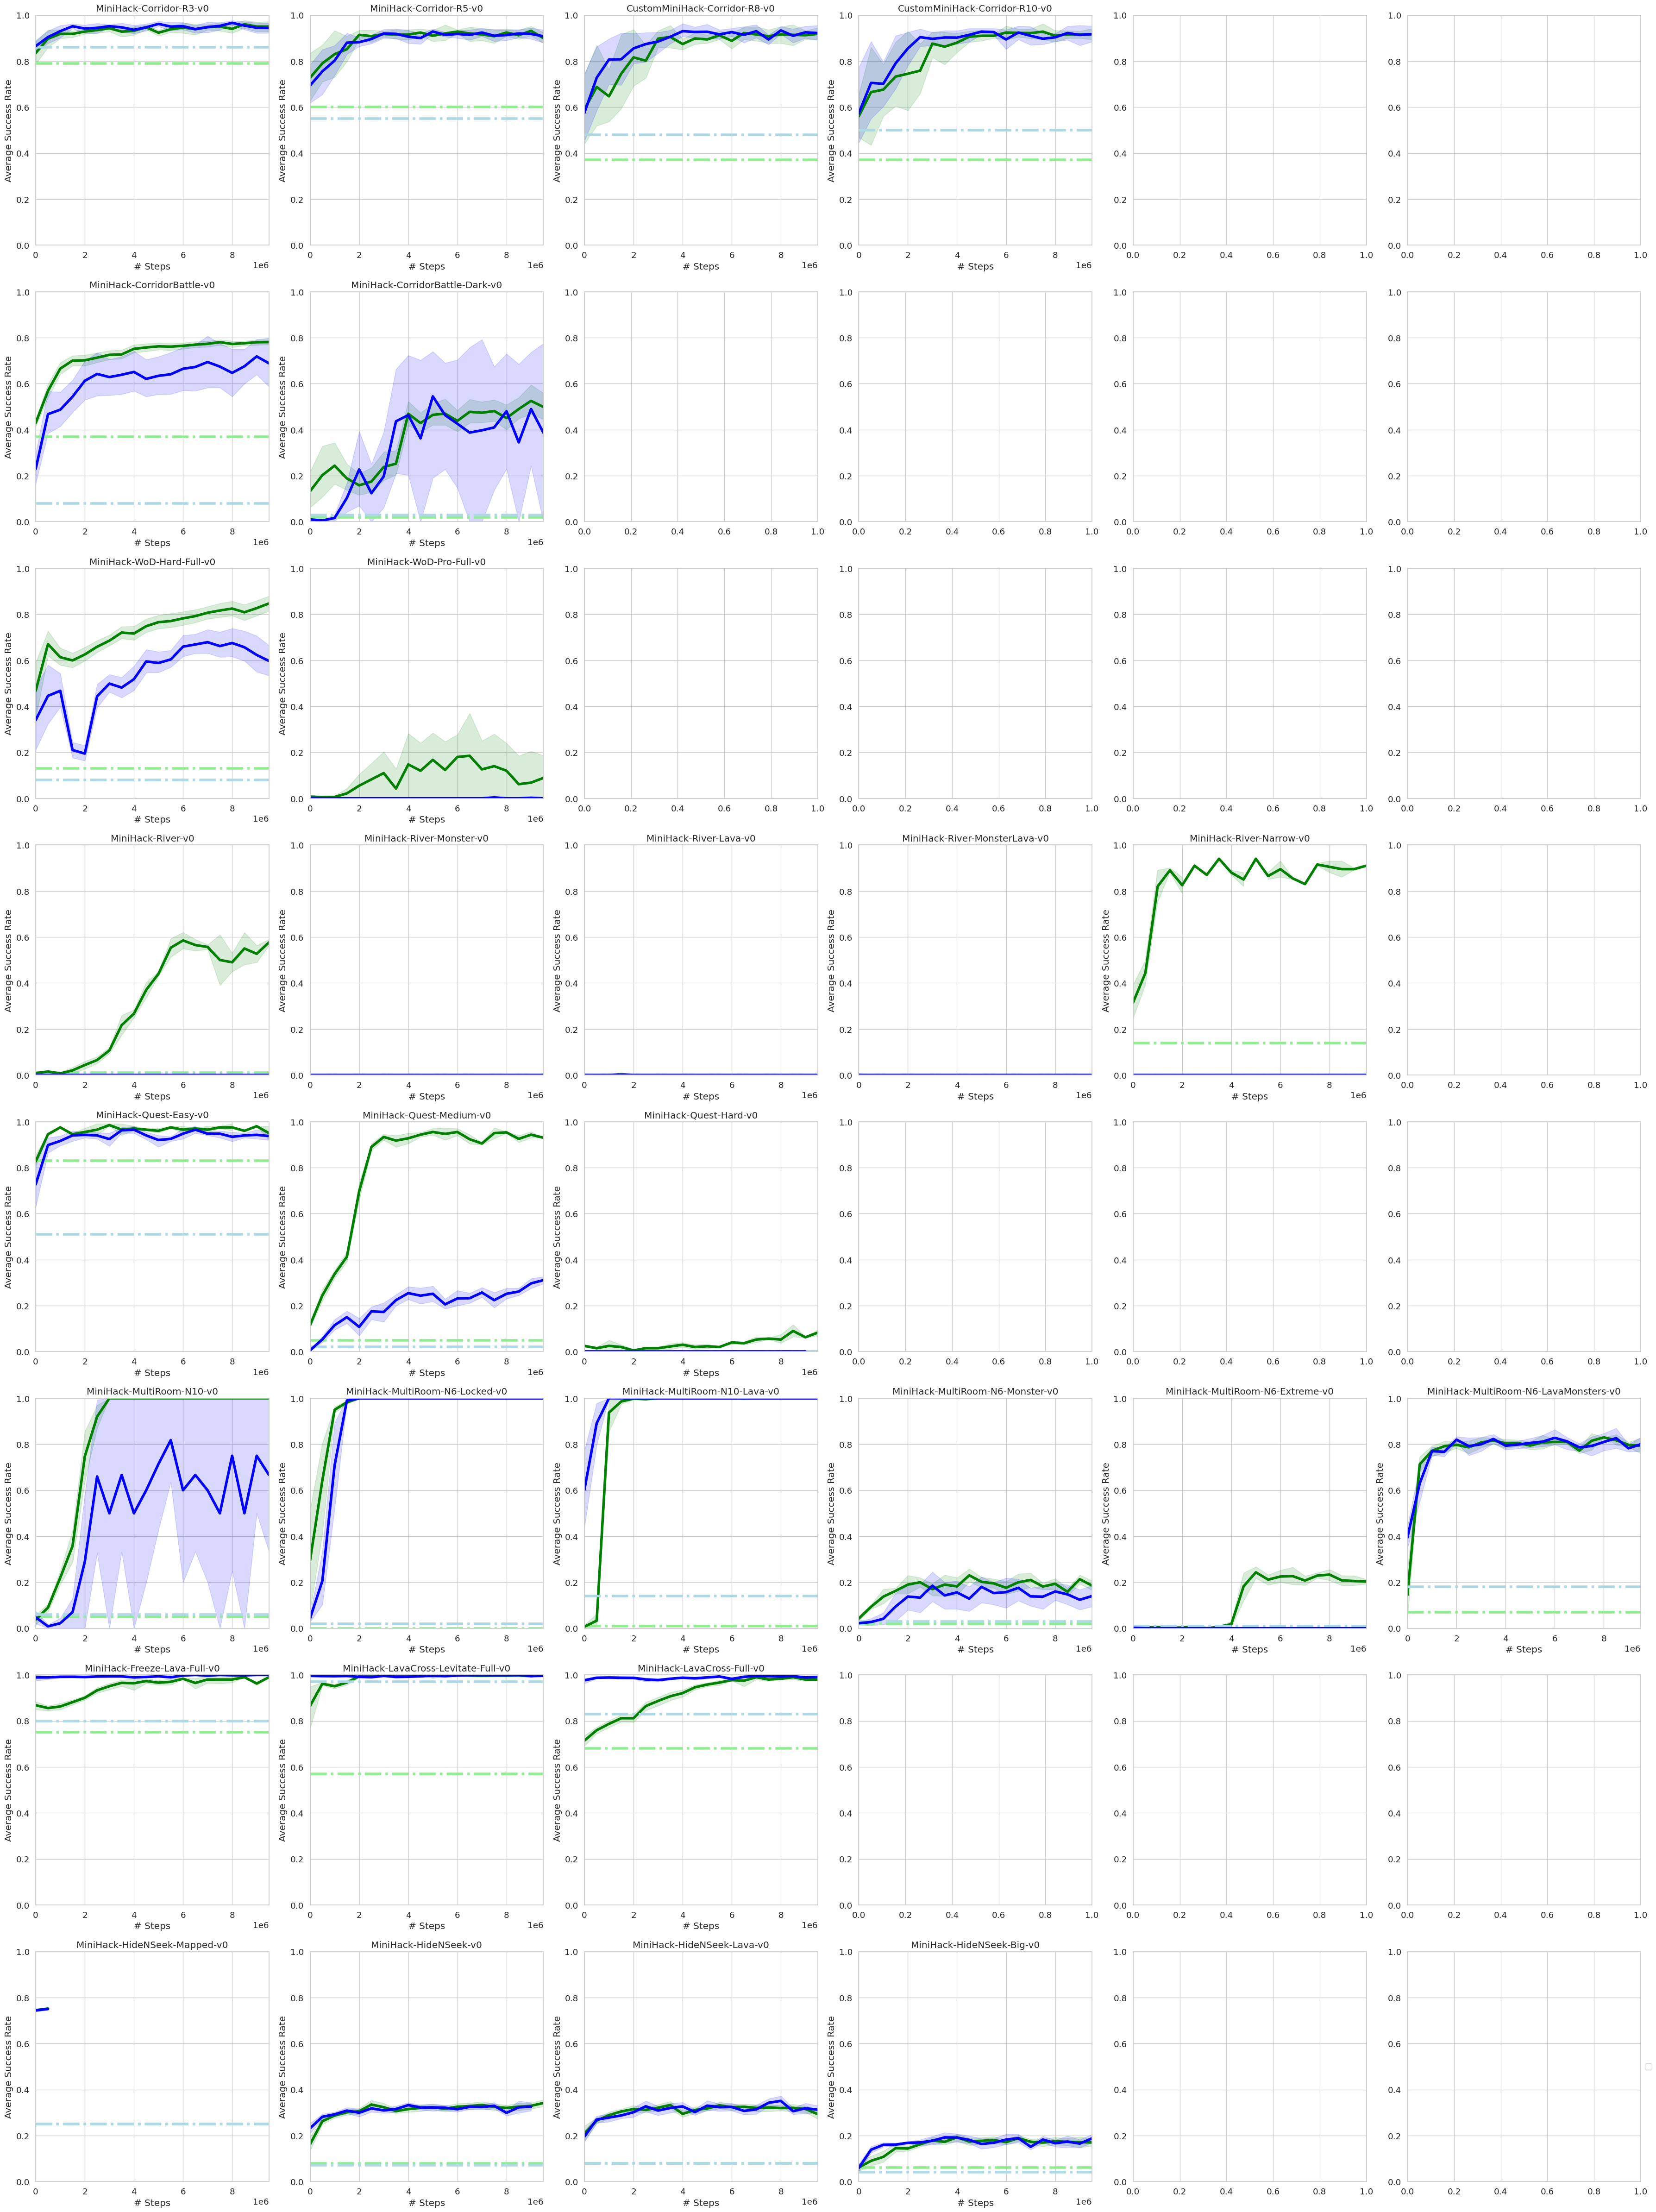

In [13]:
n_rows = len(env_groups)
n_cols = max([len(e) for e in env_groups])
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))

sns_colors = [
    "lightgreen",
    "green",
    "lightblue",
    "blue",
]
eval_column = "policy_stats/avg_success_rate"

for i, env_group in enumerate(env_groups):
    for e, env in enumerate(env_group):
        for k, difficulty in enumerate(["easy", "hard"]):
            env_data = data[data["env"] == env]
            env_data = env_data[env_data["exp_tag"].str.contains(difficulty)]

            baseline_data = random_data[random_data["env"] == env]
            baseline_data = baseline_data[baseline_data["exp_tag"].str.contains(difficulty)]
            baseline_val = baseline_data[eval_column].mean()
            axes[i][e].plot([0, 10_000_000], [baseline_val, baseline_val], linestyle='-.', label=f"random policy {difficulty}", linewidth=4, color=sns_colors[0 + 2 * k])

            legend = "full"
            sns.lineplot(data=env_data, x="index", y=eval_column, ax=axes[i][e], errorbar=('ci', 90), linewidth=4,
                            legend=legend, label=f"hrl policy {difficulty}", linestyle="-", err_kws={"alpha": .15}, color=sns_colors[1 + 2 * k])

            axes[i][e].set_ylabel("Average Success Rate")
            axes[i][e].set_xlabel("# Steps")
            axes[i][e].set_xlim(0, 10_000_000 - 500_000)
            axes[i][e].set_ylim(0, 1)
            axes[i][e].set_title(f"{env}")
            axes[i][e].get_legend().remove()

# Get the last axes
last_axes = axes[-1][-1]

# Add legend to the last axes
handles, labels = last_axes.get_lines(), [l.get_label() for l in last_axes.get_lines()]
last_axes.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# Show or save the plot
plt.show()